# Instacart Market Basket Analysis

## Index
1. Extract the data
2. Understand the data
3. Preprocesssing stage
4. Training different models to set a Benchmark
5. Improvise the Model and Repeat
6. Predict on Test data.

In [345]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [30]:
import os
# List all the data we have.
print(os.listdir('data'))

['.DS_Store', 'aisles.csv', 'departments.csv', 'order_products__prior.csv', 'order_products__train.csv', 'orders.csv', 'products.csv', 'sample_submission.csv']


# 1. Extract the Data

In [6]:
aisles      = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
order_prior = pd.read_csv('data/order_products__prior.csv')
order_train = pd.read_csv('data/order_products__train.csv')
orders      = pd.read_csv('data/orders.csv')
products    = pd.read_csv('data/products.csv')

In [50]:
print(aisles.shape)
print(aisles.head())

(134, 2)
   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation


In [51]:
print(departments.shape)
print(departments.head())

(21, 2)
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol


In [69]:
print (order_prior.shape)
print(order_prior.sort_values('order_id').head(10))

(32434489, 4)
    order_id  product_id  add_to_cart_order  reordered
0          2       33120                  1          1
1          2       28985                  2          1
2          2        9327                  3          0
3          2       45918                  4          1
4          2       30035                  5          0
5          2       17794                  6          1
6          2       40141                  7          1
7          2        1819                  8          1
8          2       43668                  9          0
16         3       32665                  8          1


In [84]:
print(order_train.shape)
print(order_train[ order_train['order_id']==1] )

(1384617, 4)
   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1
5         1       13176                  6          0
6         1       47209                  7          0
7         1       22035                  8          1


In [87]:
print(orders.shape,'\n',orders.head())

(3421083, 7) 
    order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order
0   2539329        1    prior             1          2                  8                     NaN
1   2398795        1    prior             2          3                  7                    15.0
2    473747        1    prior             3          3                 12                    21.0
3   2254736        1    prior             4          4                  7                    29.0
4    431534        1    prior             5          4                 15                    28.0
(3214874, 7)
(131209, 7)
(75000, 7)


In [73]:
print(products.shape)
print(products.head())

(49688, 4)
   product_id                                       product_name  aisle_id  department_id
0           1                         Chocolate Sandwich Cookies        61             19
1           2                                   All-Seasons Salt       104             13
2           3               Robust Golden Unsweetened Oolong Tea        94              7
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38              1
4           5                          Green Chile Anytime Sauce         5             13


## 2. Understanding Data

# 2.1 Chance of Items being ordered for first time
Percentage of old items in order vs new items in orders ~ 60%
So even though we predict all the items that will be reordered there is a 40% chance that a new item might be added by 
the user with the next order.

In [225]:
reordered = (detailed_train_data[detailed_train_data['reordered']==1].shape[0])
not_reordered = (detailed_train_data[detailed_train_data['reordered']==0].shape[0])
print( "percentage of new orders =", reordered*100 / (reordered+not_reordered))

percentage of new orders = 59.85944127509629


Lets see which group of items are popularly reordered in training set

In [204]:
# Joining orders , products and departments to give some meaningful names to each product

detailed_train_data = pd.merge(order_train,products,how='left', left_on=['product_id'], right_on = ['product_id'])
detailed_train_data = pd.merge(detailed_train_data,departments,how='left', left_on=['department_id'], right_on = ['department_id'])

In [227]:
# Extract only elements which have been ordered before
group = detailed_train_data[detailed_train_data['reordered']==1]

In [228]:
# Grouping according to individual department and getting how many orders have been placed categorically
group = group[['department','reordered','department_id']].groupby(['department','department_id']).sum()
group = group.reset_index()

# 2.2 Each department is popular in it's own way

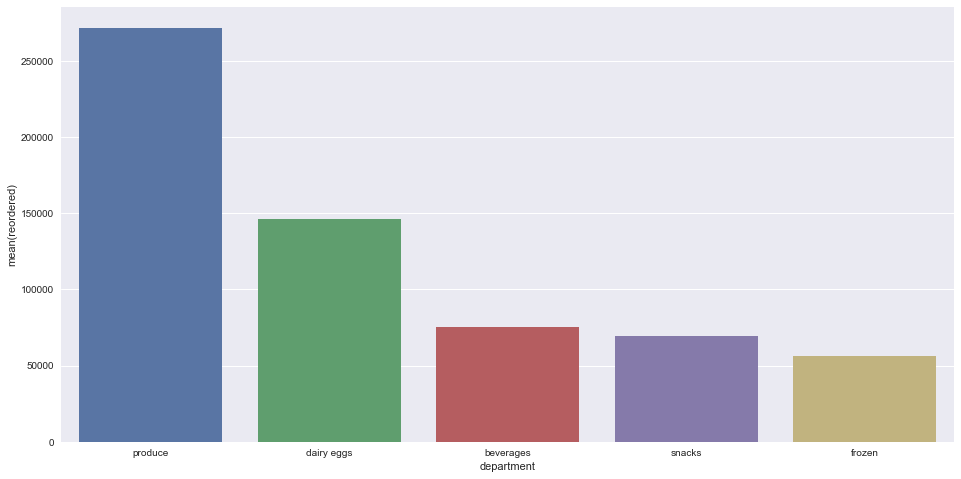

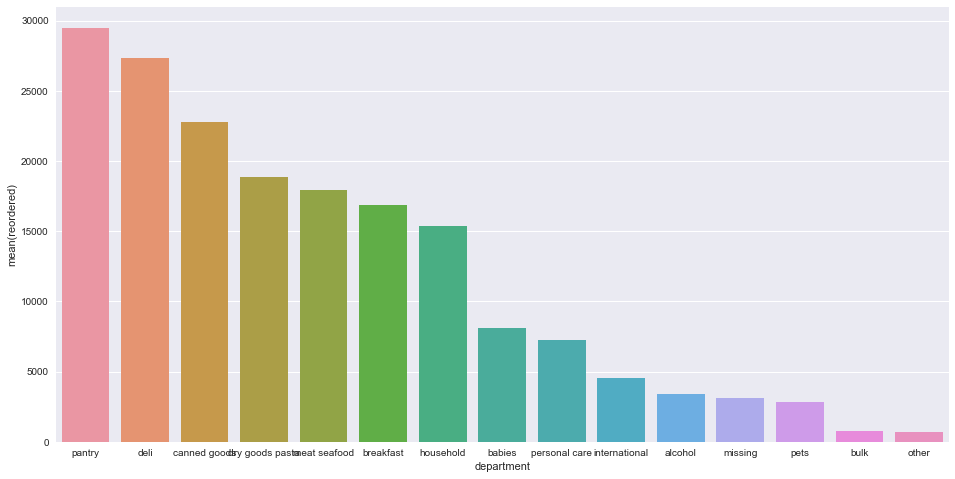

In [229]:
group = group.sort_values(by=['reordered'],ascending=[False])
plt.figure(figsize=(16,8))
sns.barplot(group.department[:5],group['reordered'])
plt.figure(figsize=(16,8))
sns.barplot(group.department[6:],group['reordered'])

# 2.2.1 It's not always about the quantity    
This analysis based on the trainig data gives us an idea that few categories are reordered relatively very high compared to others but It's not a fair way to estimate which category is being reordered more, since say if all the orders in babies department have been re-ordered It's corresponding measure should be high. So we should consider    

                       (total reorders in a category) /(total orders in each category)
                       
As we can see below though number of reorders snacks being high compared to say, pets. Ratio doesn't indicate the same. This gives a more clear picture say even if number of orders of snacks were relatively high, they are not quite reordered in the same way as pet products were.

This could indicate how we always try to experiment with snacks and also not to exclude different flavors for each product we have which might cause this behaviour as well.

In [269]:
total_group = detailed_train_data.groupby(['department','department_id']).count().reset_index()

group = group[['department','reordered','department_id']].groupby(['department','department_id']).sum()
group = group.reset_index()

In [354]:
ratio = pd.DataFrame({'department':total_group.department,'ratio':group['reordered']/total_group.reordered}).sort_values('ratio',ascending=False)

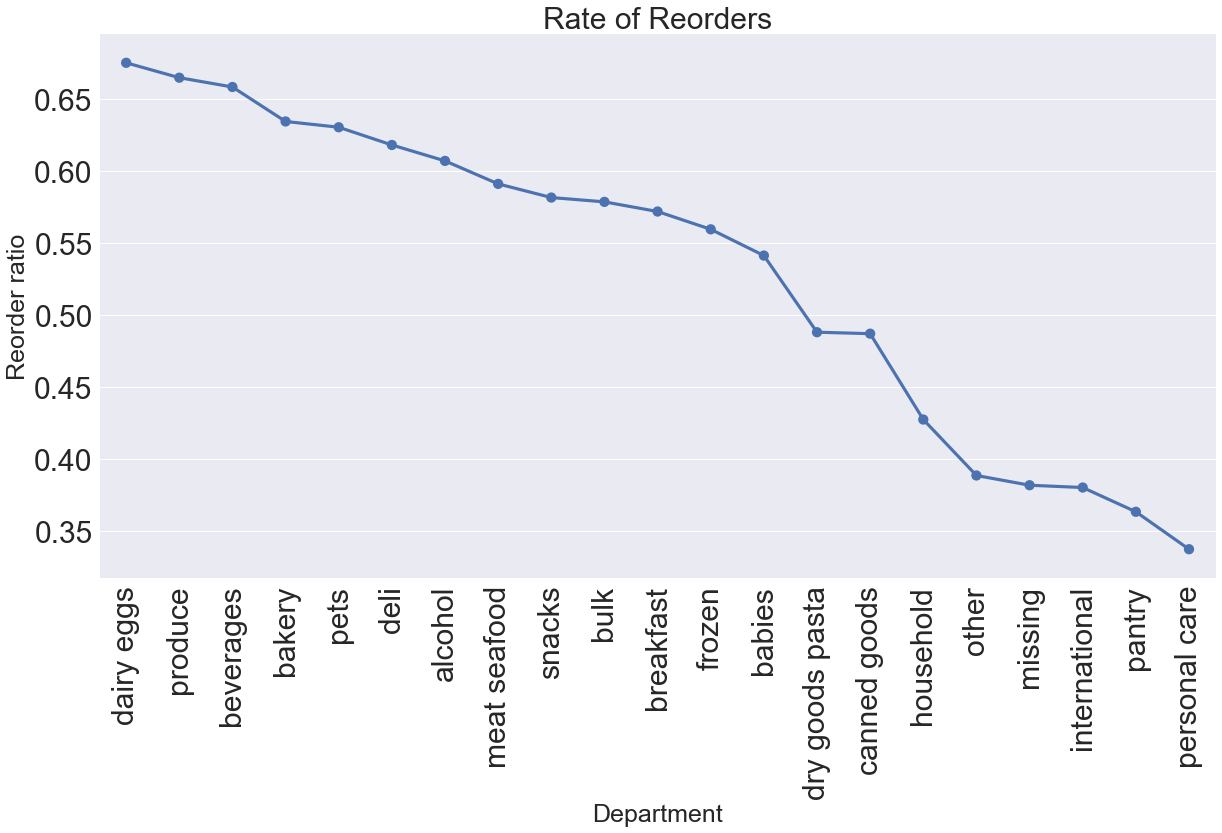

In [318]:
plt.figure(figsize=(20,10))
sns.set(font_scale=3) 
sns.pointplot(ratio.department,(ratio.ratio))
plt.xlabel('Department', fontsize=25)
plt.ylabel('Reorder ratio', fontsize=25)
plt.title("Rate of Reorders", fontsize=30)
plt.xticks(rotation='vertical')
plt.show()

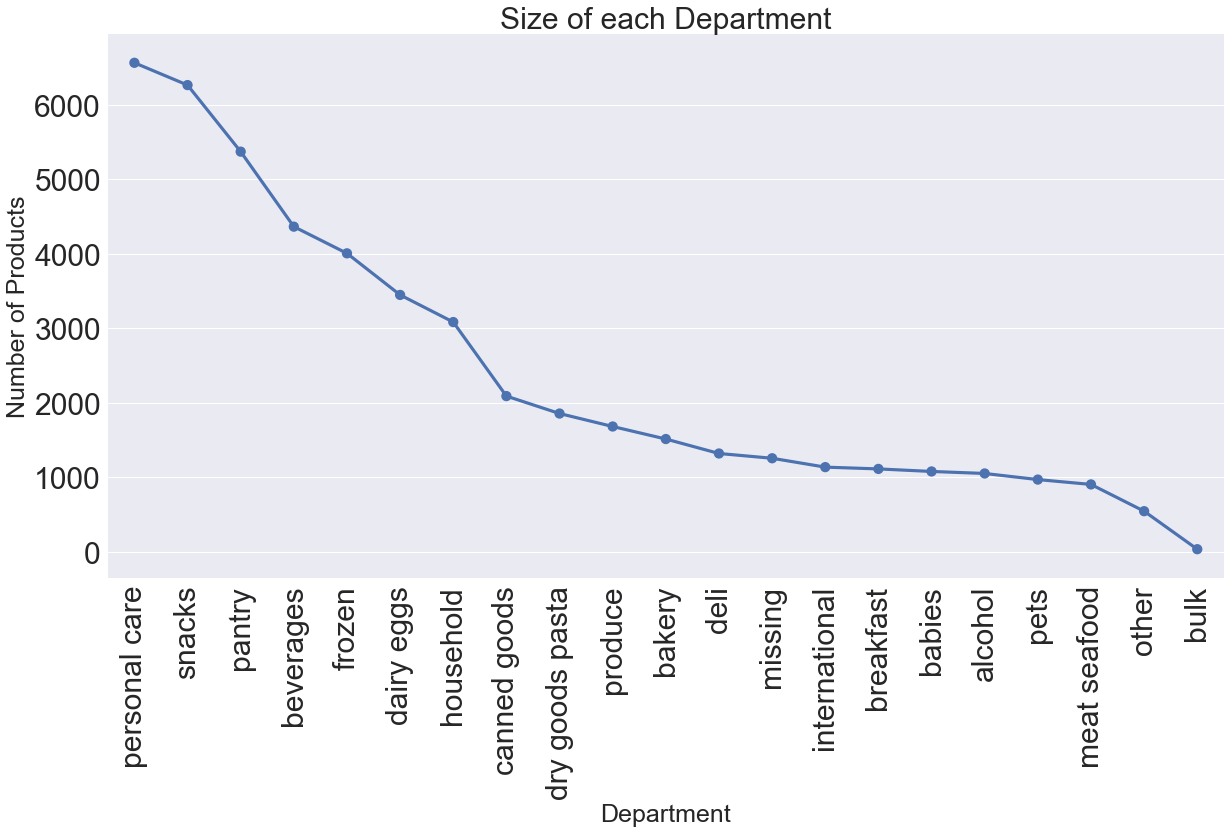

In [317]:
total_products = pd.merge(products,departments,how='left', left_on=['department_id'], right_on = ['department_id'])
total_products = total_products.groupby('department').agg('count').reset_index().sort_values('product_id',ascending=False)
total_products.product_id = total_products.product_id 
plt.figure(figsize=(20,10))
sns.set(font_scale=3) 
sns.pointplot(total_products.department,total_products.product_id)
plt.xlabel('Department', fontsize=25)
plt.ylabel('Number of Products', fontsize=25)
plt.title("Size of each Department", fontsize=30)
plt.xticks(rotation='vertical')
plt.show()


In [352]:
joint = pd.merge(total_products[['department','product_id']],ratio,on='department').reset_index()
joint.columns=['i','department','product_count','reorder_ratio']
print(joint)
scaler = MinMaxScaler()
joint[['product_count','reorder_ratio']] = scaler.fit_transform(joint[['product_count','reorder_ratio']])

     i       department  product_count  reorder_ratio
0    0    personal care           6563       0.337089
1    1           snacks           6264       0.581363
2    2           pantry           5371       0.363088
3    3        beverages           4365       0.658155
4    4           frozen           4007       0.559297
5    5       dairy eggs           3449       0.674966
6    6        household           3085       0.427166
7    7     canned goods           2092       0.486805
8    8  dry goods pasta           1858       0.487821
9    9          produce           1684       0.664617
10  10           bakery           1516       0.634211
11  11             deli           1322       0.617891
12  12          missing           1258       0.381530
13  13    international           1139       0.379936
14  14        breakfast           1115       0.571661
15  15           babies           1081       0.541062
16  16          alcohol           1054       0.606824
17  17             pets     

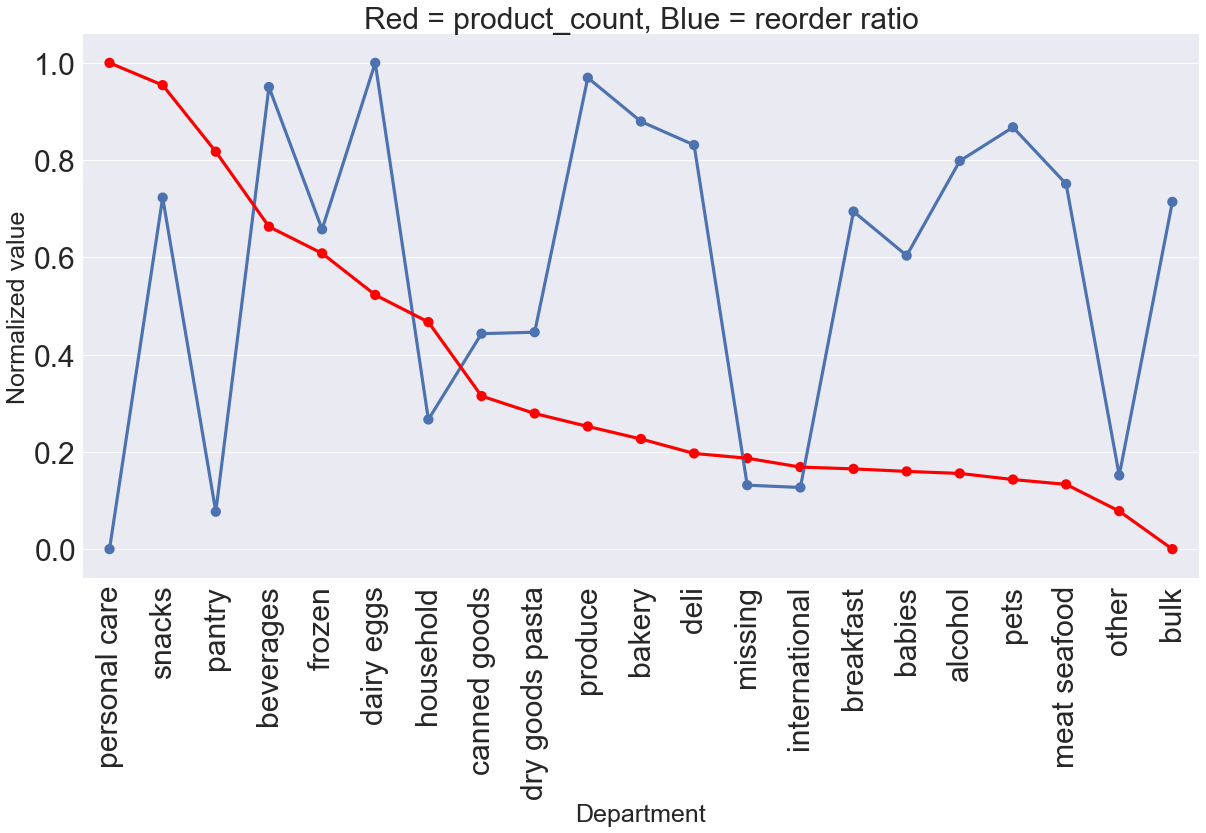

In [357]:
plt.figure(figsize=(20,10))
sns.set(font_scale=3) 
sns.pointplot(joint.department,joint.reorder_ratio)
sns.pointplot(joint.department,joint.product_count,color='red')
plt.xlabel('Department', fontsize=25)
plt.ylabel('Normalized value', fontsize=25)
plt.title("Red = product_count, Blue = reorder ratio", fontsize=30)
plt.xticks(rotation='vertical')
plt.show()

## Freedom of more
When users have more products say in case of first 3 departments the reorder ration is very less except for snacks.
It might indicate that these departments are very experimental and predicting these orders would be highly unlikely since they are available in abundance and users are not willing to order them again.